In [80]:
%matplotlib inline

import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import matplotlib
import astropy.io.fits as fits

matplotlib.rc('xtick',labelsize=12)
matplotlib.rc('ytick',labelsize=12)


# read a sample velocity data
y = np.loadtxt('Vlos.dat')

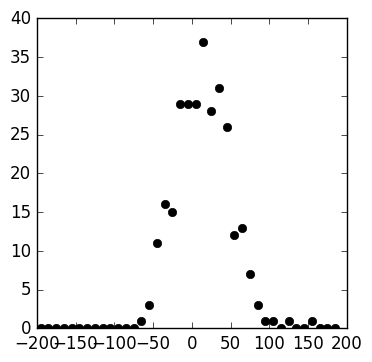

In [81]:
# draw histogram
vgrid = np.arange(-200,200,10)
vcenter = (vgrid[1:]+vgrid[:-1])/2.

hv,xedge = np.histogram(y,vgrid)

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.plot(vcenter, hv, 'ko')
ax.set_label('V')

fig.show()

14.2598639456 1162.4809092
293 1162.4809092
1662 1
(1662, 1)


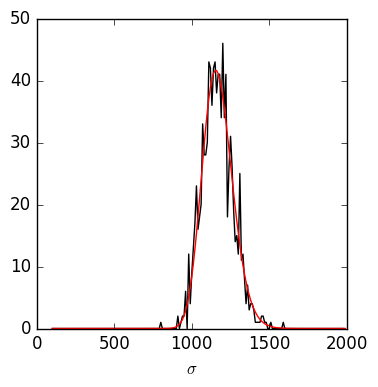

In [95]:
#ask for the mean velocity and the velocity dispersion, providing that the velocity distributionis Gaussian
#known mean redshift ask dispersion, as homework
def logit(x):
    return np.log10(x/(1.-x))

def InvGamma(x,alpha,beta):
    y = np.log(beta)*alpha-np.log(special.gamma(alpha))+np.log(x)*(-alpha-1)-beta/x
    return np.exp(y)

def Scl_InvChi2(x, nu, s2):
    return InvGamma(x, nu/2.,nu/2.*s2)

def randDraw_SInvChi2(nu,s2, N):
    x = []
    k = 0
    m = 0
    while k<N and m <= 3:
        x0 = np.random.uniform(low=0,high=2000,size=N*20)
        y0 = np.random.uniform(low=0,high=0.006,size=N*20)
        #x0 = logit(x0)
        y1 = Scl_InvChi2(x0, nu, s2)
        print nu,s2
        ind = (y0<y1)
        x.append(x0[ind])
        k = k + np.sum(ind)
        m += 1
        print k,m
    xx = np.array(x).reshape((k,1))
    print np.shape(xx)
    return (xx[0:N])

# sampling
n = len(y)
y_bar = np.sum(y)/n
s2 = np.sum((y-y_bar)**2)/(n-1.)
print y_bar, s2
#step 1: draw sigma2 from posterior density of sigma2 given v, p(sigma2|y)
N = 1000
sigma2 = randDraw_SInvChi2(n-1,s2, N)

#draw the random draw of sigma
x = np.arange(100,2000,10)
y1 = Scl_InvChi2(x, nu, s2)
hy,xedge = np.histogram(sigma2,x)

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.plot(x[0:-1],hy,'k')
ax.plot(x,y1/sum(y1)*sum(hy),'r')
ax.set_xlabel(r'$\sigma$',fontsize=12)
fig.show()

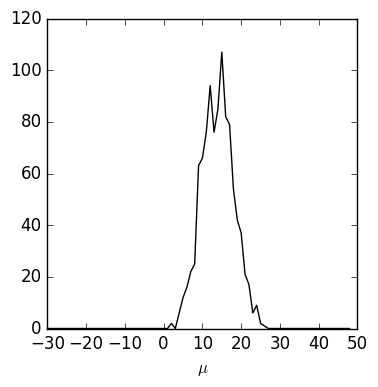

In [106]:
#step 2: draw mu from p(mu|sigma2,y)
mu = np.random.normal(loc=y_bar,scale=sigma2/n)



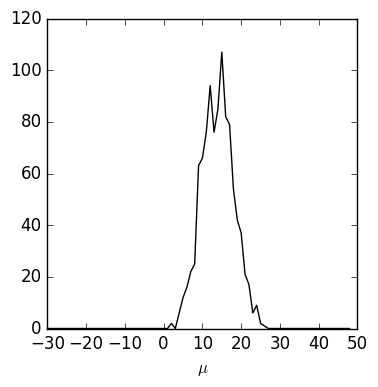

In [107]:
#step 3: marginalize over sigma2
#draw the random draw of sigma
x = np.arange(-30,50,1)
hy,xedge = np.histogram(mu,x)

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.plot(x[0:-1],hy,'k')
ax.set_xlabel(r'$\mu$',fontsize=12)
fig.show()
